# DCN


# 1. Install & Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 3.7MB 4.0MB/s 


In [3]:

import os
import pandas as pd

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
import glob

# 2. Preprocess

In [4]:
train = pd.read_json('/content/drive/MyDrive/tobigs14_conference/data/v_2/wine_meta/train_all_meta_v2.json')
test = pd.read_json('/content/drive/MyDrive/tobigs14_conference/data/v_2/wine_meta/test_all_meta_v2.json')

In [5]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [7]:
train.country_code= train.country_code.fillna('un')
train.winery_id= train.winery_id.fillna('un')

In [8]:
train['grapes_id_unique'] = train.grapes_id.map(lambda x: x[0] if x else 0)

In [9]:
train = train[~train.food.isna()].reset_index(drop=True)

In [10]:
train=train.drop(train[train['rank'].isna()].index)

In [11]:
train=train[~train.type_id.isna()]
train=train[~train.type_id.isna()]

In [12]:
train=train.drop(train[train['type_id']==25].index)

In [13]:
train = train[~train.body.isna()].reset_index(drop=True)
train = train[~train.winery_id.isna()].reset_index(drop=True)
train = train[~train.region_id.isna()].reset_index(drop=True)

float 형태 데이터: rating_per_user, rating_average, winery_ratings_average, <br>
grapes_id랑 같은 형태: country_most_used_grapes_wine_count, 

In [14]:
INT_FEATURES = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol']

for int_feature in INT_FEATURES:
  train[int_feature] = train[int_feature].astype(int)

train.country_code= train.country_code.fillna('un')

In [15]:
train['grapes_id_unique'] = train.grapes_id.map(lambda x: x[0] if x else 0)

# test data 생성

In [16]:
test = test[~test.body.isna()].reset_index(drop=True)
test = test[~test.winery_id.isna()].reset_index(drop=True)
test = test[~test.region_id.isna()].reset_index(drop=True)

In [17]:
INT_FEATURES = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol']


for int_feature in INT_FEATURES:
  test[int_feature] = test[int_feature].astype(int)

test.country_code= test.country_code.fillna('un')
test['grapes_id_unique'] = test.grapes_id.map(lambda x: x[0] if x else 0)

- int: type_id, body, acidity, like, user_like_count, alcohol, grapes_id, winery_id
- str: UserID, wine_id, country_code, 

# dic type변경

In [18]:
INT_FEATURES = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol']

In [19]:
str_features = ["userID", "country_code", 'wine_id']
int_features = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'grapes_id_unique']

In [20]:
train_str_dict = {
    str_feature: [str(val).encode() for val in train[str_feature].values]
    for str_feature in str_features
}

train_int_dict = {
    int_feature: train[int_feature].values
    for int_feature in int_features
}

In [21]:
train_str_dict.update(train_int_dict)
train_str_dict.keys()

dict_keys(['userID', 'country_code', 'wine_id', 'type_id', 'body', 'acidity', 'like', 'user_like_count', 'rating_count', 'alcohol', 'grapes_id_unique'])

In [22]:
test_str_dict = {
    str_feature: [str(val).encode() for val in test[str_feature].values]
    for str_feature in str_features
}

test_int_dict = {
    int_feature: test[int_feature].values
    for int_feature in int_features
}

test_str_dict.update(test_int_dict)
test_str_dict.keys()

dict_keys(['userID', 'country_code', 'wine_id', 'type_id', 'body', 'acidity', 'like', 'user_like_count', 'rating_count', 'alcohol', 'grapes_id_unique'])

In [23]:
train = tf.data.Dataset.from_tensor_slices(train_str_dict)
test = tf.data.Dataset.from_tensor_slices(test_str_dict)

In [25]:
# tf.keras.layers.experimental.preprocessing.
feature_names = ["userID", "country_code", 'grapes_id_unique', "type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'wine_id']

In [26]:
vocabularies = {}

for feature_name in feature_names:
  vocab = train.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [27]:
vocabularies

{'acidity': array([1, 2, 3]),
 'alcohol': array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  80, 112, 114, 135]),
 'body': array([1, 2, 3, 4, 5]),
 'country_code': array([b'ar', b'at', b'au', b'br', b'ca', b'ch', b'cl', b'de', b'es',
        b'fr', b'gb', b'gr', b'hu', b'il', b'it', b'jp', b'lu', b'mx',
        b'nz', b'pt', b'ru', b'us', b'uy', b'za'], dtype=object),
 'grapes_id_unique': array([   0,    1,    2,    3,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   29,   31,   32,   33,   34,   35,   36,   37,
          38,   39,   40,   41,   42,   43,   44,   45,   46,   47,   48,
          49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
          62,   63,   64,   67,   68,   69,   70,   71,   74,   75,   76,
          77,   78,   80,   81,   82,   83,   85,   86,   88,   89,   91,
          92,   93,   94, 

# Model

In [38]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["userID", "country_code", 'wine_id']
    int_features = ["type_id", "body", "acidity", 'user_like_count', 'rating_count', 'alcohol', 'grapes_id_unique']

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryCrossentropy("binary_accuracy")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("like")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [39]:
learning_rate = 0.001

In [40]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(5989).cache()

In [41]:
model = DCN(use_cross_layer=True, deep_layer_sizes=[192, 192], projection_dim=None)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

# Train & Result

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds

cached_test_numpy = tfds.as_numpy(cached_test)
y_true = [item['like'] for item in cached_test_numpy]
y_true = np.concatenate(y_true)

In [43]:
def get_result(model):
  y_pred = model.predict(cached_test).flatten()
  y_pred_class = [1 if pred > 0.5 else 0 for pred in y_pred]

  print(f"ROC: {roc_auc_score(y_true, y_pred)}")
  print(classification_report(y_true, y_pred_class))

In [44]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=20)

In [45]:
history= model.fit(cached_train,  epochs=500, verbose=True, callbacks=[callback])

Epoch 1/500
87/87 [==============================] - 11s 108ms/step - binary_accuracy: 0.6361 - loss: 0.6352 - regularization_loss: 0.0000e+00 - total_loss: 0.6352
Epoch 2/500
87/87 [==============================] - 2s 21ms/step - binary_accuracy: 0.5438 - loss: 0.5423 - regularization_loss: 0.0000e+00 - total_loss: 0.5423
Epoch 3/500
87/87 [==============================] - 2s 21ms/step - binary_accuracy: 0.5174 - loss: 0.5155 - regularization_loss: 0.0000e+00 - total_loss: 0.5155
Epoch 4/500
87/87 [==============================] - 2s 21ms/step - binary_accuracy: 0.5058 - loss: 0.5036 - regularization_loss: 0.0000e+00 - total_loss: 0.5036
Epoch 5/500
87/87 [==============================] - 2s 21ms/step - binary_accuracy: 0.4978 - loss: 0.4958 - regularization_loss: 0.0000e+00 - total_loss: 0.4958
Epoch 6/500
87/87 [==============================] - 2s 21ms/step - binary_accuracy: 0.4938 - loss: 0.4918 - regularization_loss: 0.0000e+00 - total_loss: 0.4918
Epoch 7/500
87/87 [=======

In [46]:
get_result(model)

ROC: 0.9223335284801448
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     80975
           1       0.85      0.88      0.86     93390

    accuracy                           0.85    174365
   macro avg       0.85      0.85      0.85    174365
weighted avg       0.85      0.85      0.85    174365



In [47]:
model.summary()

Model: "dcn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 32)                128       
_________________________________________________________________
sequential_18 (Sequential)   (None, 32)                800       
_________________________________________________________________
sequential_14 (Sequential)   (None, 32)                192       
_________________________________________________________________
sequential_11 (Sequential)   (None, 32)                800       
_________________________________________________________________
sequential_19 (Sequential)   (None, 32)                12768     
_________________________________________________________________
sequential_17 (Sequential)   (None, 32)                247584    
_________________________________________________________________
sequential_13 (Sequential)   (None, 32)                224   

<Figure size 7200x7200 with 0 Axes>

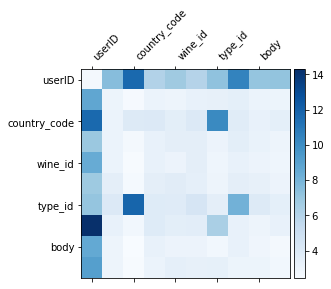

In [50]:
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(100,100))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)